In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# 1. Inspecting the data

In [2]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Comparing survival rate across various categorical variables

C:\Users\Amin\AppData\Local\Temp\ipykernel_15720\340755965.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Survived", data=group_data, palette="viridis")
C:\Users\Amin\AppData\Local\Temp\ipykernel_15720\340755965.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Survived", data=group_data, palette="viridis")
C:\Users\Amin\AppData\Local\Temp\ipykernel_15720\340755965.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Survived", data=group_data, palette="viridis")
C:\Users\Amin\AppData\Local\Temp\ipykern

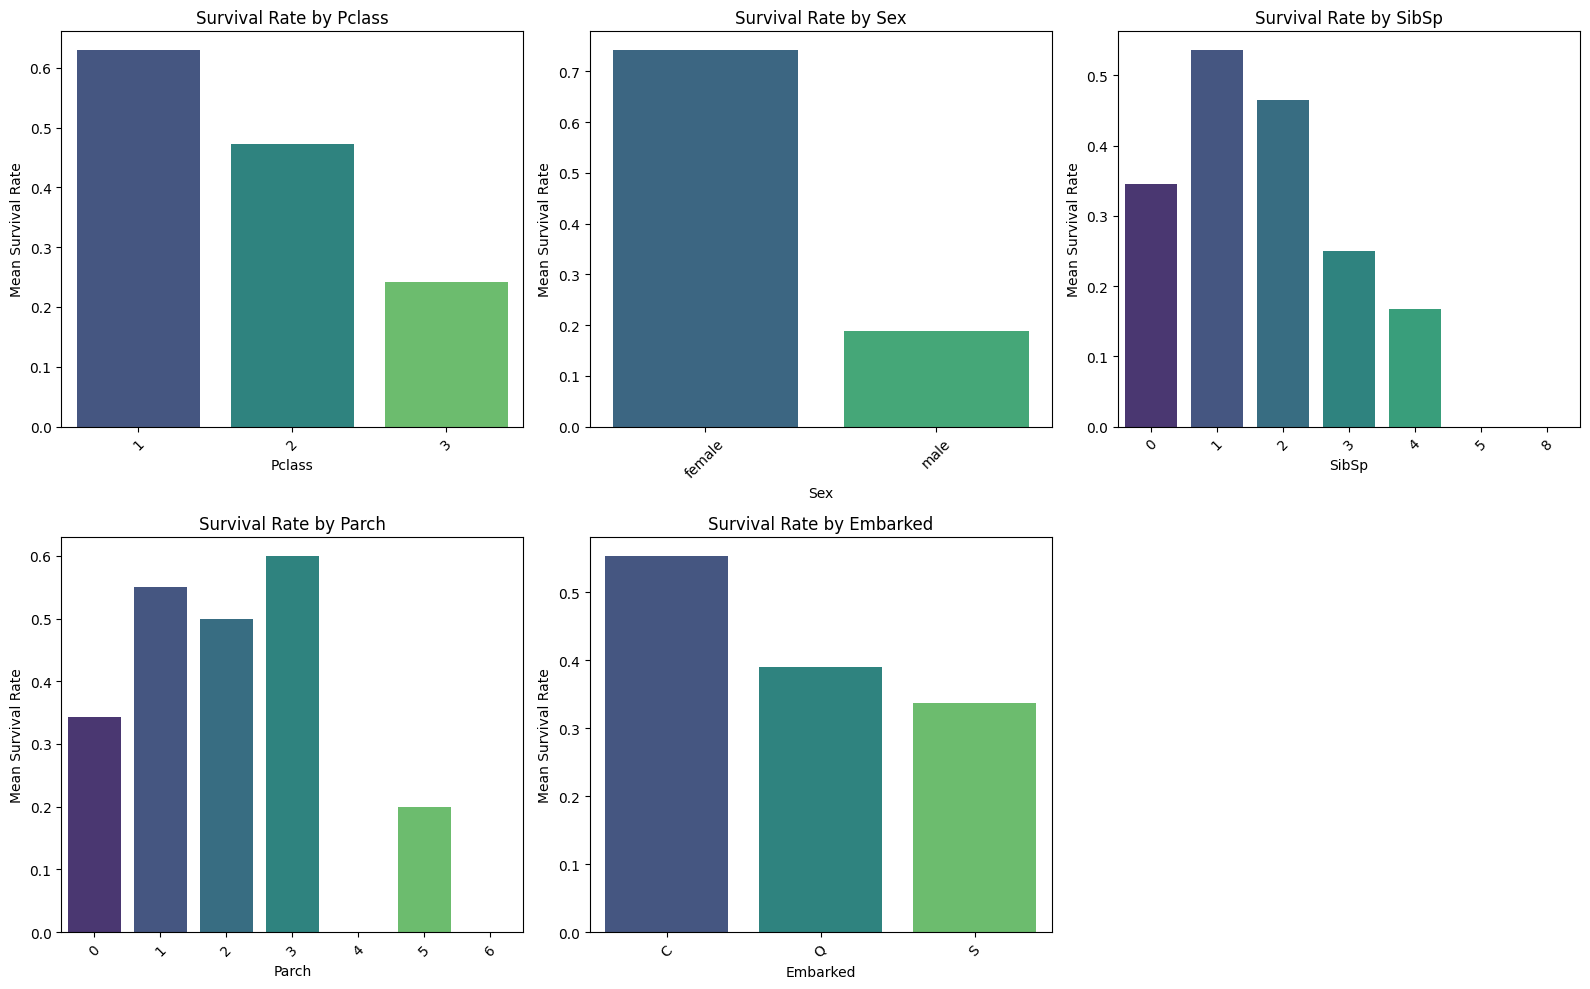

In [ ]:
# Columns to analyze
cols = train_data.columns[[2, 4, 6, 7, 11]]  # ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

# Set up the plot
plt.figure(figsize=(16, 10)) 

# Loop through each column and create a subplot
for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns of subplots
    group_data = train_data.groupby(col)["Survived"].mean().reset_index()

    # Plot barplot
    sns.barplot(x=col, y="Survived", data=group_data, palette="viridis")
    plt.title(f"Survival Rate by {col}")
    plt.ylabel("Mean Survival Rate")
    plt.xlabel(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Comparing survival rate across age groups

Text(0, 0.5, 'Survival Rate')

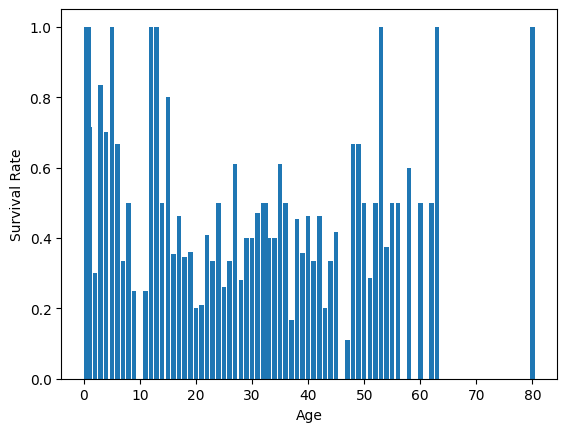

In [4]:
average_survival_rate_per_age = train_data.groupby("Age",as_index=False)["Survived"].mean()
plt.bar(average_survival_rate_per_age['Age'],average_survival_rate_per_age['Survived'])

plt.xlabel('Age')
plt.ylabel('Survival Rate')

### Comparing survival rate across fare groups

Text(0, 0.5, 'Survival Rate')

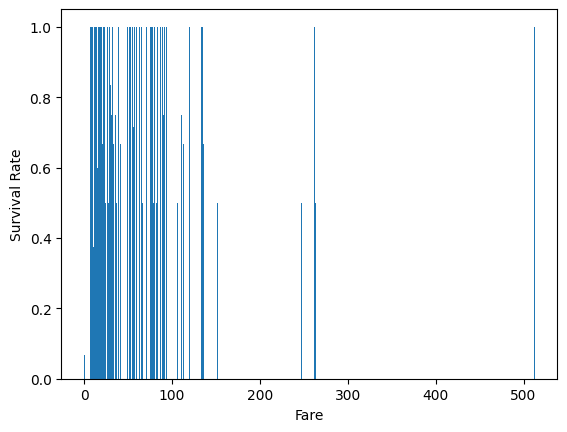

In [5]:
average_survival_rate_per_fare_group = train_data.groupby("Fare",as_index=False)["Survived"].mean()
plt.bar(average_survival_rate_per_fare_group['Fare'],average_survival_rate_per_fare_group['Survived'])

plt.xlabel('Fare')
plt.ylabel('Survival Rate')

# Selecting the features

In [ ]:
train_data['is_male'] = pd.get_dummies(train_data['Sex'],drop_first=True)
test_data['is_male'] = pd.get_dummies(test_data['Sex'],drop_first=True)

features = ['Age', 'is_male', 'Fare', 'Pclass', 'SibSp', 'Parch']

X_train = train_data[features]
X_test = test_data[features]
y = train_data["Survived"]

# 1. Training a random forest

In [ ]:
# 1. Define the pipeline
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('random_forest', RandomForestClassifier(
        n_estimators=1000,
        random_state=1
    ))
])

# 2. Set up the grid of hyperparameters to search
param_grid = {
    'random_forest__max_depth':        [3, 5, 7, 9, None],
    'random_forest__min_samples_leaf': [5, 10, 15],
    'random_forest__class_weight':     [None, 'balanced', 'balanced_subsample',
                                        {0: 1, 1: 1.5}, {0: 1, 1: 2}]  # example custom mapping
}

# 3. Create the GridSearchCV object
grid_rf = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', 
    n_jobs=-1,          # use all cores
    verbose=1
)

# 4. Fit to the training data
predictions = grid_rf.fit(X_train, y).predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submissions/submission_RF.csv', index=False)

# 5. Inspect the best parameters and best score
print("Best max_depth:", grid_rf.best_params_['random_forest__max_depth'])
print("Best CV accuracy:", grid_rf.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best max_depth: 9
Best CV accuracy: 0.8227229929069111


##### Interpreting

   Feature  Importance
0  is_male    0.439106
1     Fare    0.214155
2      Age    0.138183
3   Pclass    0.130200
4    SibSp    0.046652
5    Parch    0.031704


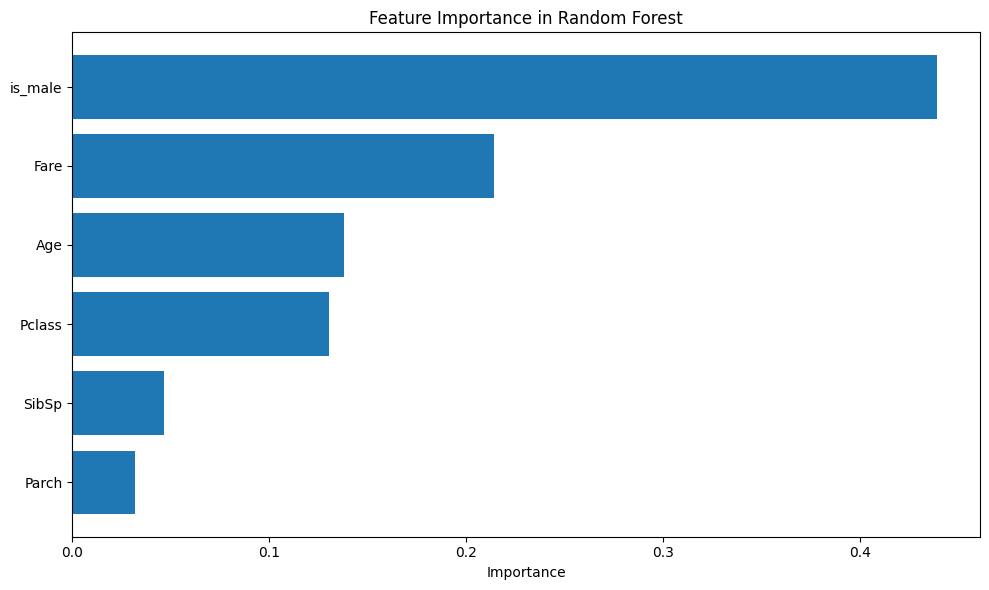

In [ ]:
# 1. After grid search, get the best pipeline
best_pipe = grid_rf.best_estimator_

# 2. Extract the trained RandomForestClassifier
rf = best_pipe.named_steps['random_forest']

# 3. Get importances
importances = rf.feature_importances_

# 4. Get the feature names
feature_names = X_train.columns

# 5. Build a DataFrame and sort
feature_importance_df = (
    pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

# 6. Display the top features
print(feature_importance_df)

# 7. Plot
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['Feature'],
    feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # highest importance at the top
plt.tight_layout()
plt.show()

# Logistic Regression

In [ ]:
# 1. Define the pipeline: impute → scale → logistic regression
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),               # advisable for LR
    ('logreg',  LogisticRegression(max_iter=5000, random_state=1, solver='liblinear' ))
])

# 2. Set up the hyperparameter grid for LogisticRegression
param_grid_lr = [
    # lbfgs: no penalty or L2
    {
      'logreg__solver':       ['lbfgs'],
      'logreg__penalty':      [None, 'l2'],
      'logreg__C':            [0.1, 1, 10],
      'logreg__class_weight': [None, 'balanced']
    },
    # liblinear: L1 or L2
    {
      'logreg__solver':       ['liblinear'],
      'logreg__penalty':      ['l1', 'l2'],
      'logreg__C':            [0.1, 1, 10],
      'logreg__class_weight': [None, 'balanced']
    },
    # saga: L1, L2, elasticnet
    {
      'logreg__solver':       ['saga'],
      'logreg__penalty':      ['l1', 'l2', 'elasticnet'],
      'logreg__C':            [0.1, 1, 10],
      'logreg__l1_ratio':     [0.5],                   # only for elasticnet
      'logreg__class_weight': [None, 'balanced']
    }
]

# 3. Create the GridSearchCV object
grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',   # still optimizing for accuracy
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# 4. Fit on the training data and predict on test set
grid_lr.fit(X_train, y)
predictions_lr = grid_lr.predict(X_test)

# 5. Save 
output_lr = pd.DataFrame({
    'PassengerId': test_data.PassengerId,
    'Survived':    predictions_lr
})
output_lr.to_csv('submissions/submission_LR.csv', index=False)

# 6. Inspect best parameters and CV score
print("Best C:           ", grid_lr.best_params_['logreg__C'])
print("Best penalty:     ", grid_lr.best_params_['logreg__penalty'])
print("Best class_weight:", grid_lr.best_params_['logreg__class_weight'])
print("Best CV accuracy: ", grid_lr.best_score_)


Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best C:            1
Best penalty:      l1
Best class_weight: None
Best CV accuracy:  0.7867553825874082


c:\Users\Amin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


### Interpreting

   feature  coefficient  odds_ratio
1  is_male    -1.303093    0.271690
3   Pclass    -0.896408    0.408033
0      Age    -0.494721    0.609741
4    SibSp    -0.367518    0.692451
2     Fare     0.130956    1.139918
5    Parch    -0.076622    0.926240


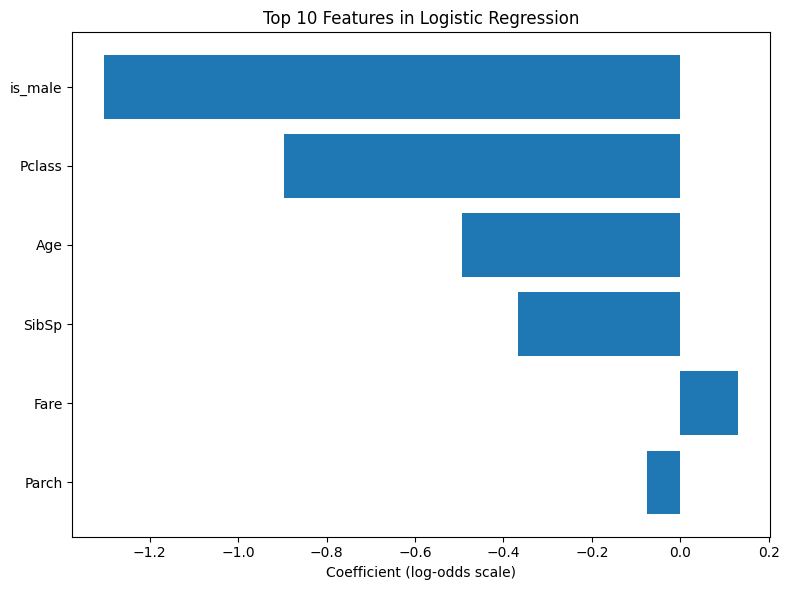

In [ ]:
# 1. Extract best‐found pipeline and logistic step
best_pipe = grid_lr.best_estimator_
best_lr   = best_pipe.named_steps['logreg']

# 2. Get feature names 
feature_names = X_train.columns

# 3. Pull out raw coefficients and compute odds ratios
coefs      = best_lr.coef_[0]
odds_ratios = np.exp(coefs)

# 4. Build a DataFrame
coef_df = pd.DataFrame({
    'feature':     feature_names,
    'coefficient': coefs,
    'odds_ratio':  odds_ratios
})

# 5. Sort by absolute distance from OR=1 (largest effect)
coef_df['effect_size'] = np.abs(coef_df['odds_ratio'] - 1)
coef_df = coef_df.sort_values('effect_size', ascending=False).drop(columns='effect_size')

print(coef_df)

# 6. Plot the top features by absolute coefficient
top10 = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index).head(10)

plt.figure(figsize=(8,6))
plt.barh(top10['feature'], top10['coefficient'])
plt.xlabel('Coefficient (log-odds scale)')
plt.title('Top 10 Features in Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Voting Claasifier

In [ ]:
# 1. Prepare the base estimators (with their best hyperparameters)
best_rf = grid_rf.best_estimator_
best_lr = grid_lr.best_estimator_

# 2. Build a VotingClassifier 
voter = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('lr', best_lr),
    ],
    voting='soft',
    n_jobs=-1
)

# 3. Define the grid over the weights you want to try
#    each list is [weight_for_rf, weight_for_lr]
param_grid_voter = {
    'weights': [
        [1, 1],
        [1.5, 1],
        [1, 1.5],
        [2, 1],
        [1, 2],
    ]
}

# 4. Wrap in GridSearchCV
grid_voter = GridSearchCV(
    estimator=voter,
    param_grid=param_grid_voter,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 5. Fit on the training data
grid_voter.fit(X_train, y)

# 6. Inspect the best weights and CV score
print("Best weights (rf, lr):", grid_voter.best_params_['weights'])
print("Best CV accuracy:    ", grid_voter.best_score_)

# 7. Use the best voting model to predict on test set
best_voter = grid_voter.best_estimator_
preds_voting = best_voter.predict(X_test)

# 8. Save submission
output_voting = pd.DataFrame({
    'PassengerId': test_data.PassengerId,
    'Survived':    preds_voting
})
output_voting.to_csv('submissions/submission_voting.csv', index=False)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best weights (rf, lr): [1.5, 1]
Best CV accuracy:     0.8103195028560668
